# COVID-Net CT Inference and Grad-CAM
This notebook provides some basic inference and visualization code for COVID-Net CT models. In particular, it includes example code for:
1. Preprocessing images
2. Running inference on single images or full CT volumes
3. Computing and displaying Grad-CAM visualizations of the predicitions

## Initial setup
COVID-Net CT models may be downloaded using the links on [this page](docs/models.md). Once downloaded, the paths below should be set to reflect the location and name of the model you wish to use. If you are not using an official COVID-Net CT model, the tensor names may also need to be changed.

In [4]:
# Model directory, metagraph file name, and checkpoint name
MODEL_DIR = 'models/COVID-Net_CT-2_L'
META_NAME = 'model.meta'
CKPT_NAME = 'model'

# Tensor names
IMAGE_INPUT_TENSOR = 'Placeholder:0'
TRAINING_PH_TENSOR = 'is_training:0'
FINAL_CONV_TENSOR = 'resnet_model/block_layer4:0'
CLASS_PRED_TENSOR = 'ArgMax:0'
CLASS_PROB_TENSOR = 'softmax_tensor:0'
LOGITS_TENSOR = 'resnet_model/final_dense:0'

# Class names, in order of index
CLASS_NAMES = ('Normal', 'Pneumonia', 'COVID-19')

In [13]:
import os
import cv2
import glob
import itertools
import numpy as np

IMG_EXTENSIONS = ('png', 'jpg', 'jpeg', 'tif', 'bmp')
HU_WINDOW_WIDTH = 1500
HU_WINDOW_CENTER = -600


def hu_to_uint8(hu_images, window_width, window_center):
    """Converts HU images to uint8 images"""
    images = (hu_images.astype(np.float) - window_center + window_width/2)/window_width
    uint8_images = np.uint8(255.0*np.clip(images, 0.0, 1.0))
    return uint8_images


def ensure_uint8(data, window_width=HU_WINDOW_WIDTH, window_center=HU_WINDOW_CENTER):
    """Converts non-uint8 data to uint8 and applies window level to HU data"""
    if data.dtype != np.uint8:
        if data.ptp() > 255:
            # Assume HU
            data = hu_to_uint8(data, window_width, window_center)
        else:
            # Assume uint8 range with incorrect dtype
            data = data.astype(np.uint8)
    return data


def find_contours(binary_image):
    """Helper function for finding contours"""
    return cv2.findContours(binary_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)[0]


def body_contour(binary_image):
    """Helper function to get body contour"""
    contours = find_contours(binary_image)
    areas = [cv2.contourArea(cnt) for cnt in contours]
    body_idx = np.argmax(areas)
    return contours[body_idx]


def auto_body_crop(image, scale=1.0):
    """Roughly crop an image to the body region"""
    # Create initial binary image
    filt_image = cv2.GaussianBlur(image, (5, 5), 0)
    thresh = cv2.threshold(filt_image[filt_image > 0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]
    bin_image = np.uint8(filt_image > thresh)
    erode_kernel = np.ones((7, 7), dtype=np.uint8)
    bin_image = cv2.erode(bin_image, erode_kernel)

    # Find body contour
    body_cont = body_contour(bin_image).squeeze()

    # Get bbox
    xmin = body_cont[:, 0].min()
    xmax = body_cont[:, 0].max() + 1
    ymin = body_cont[:, 1].min()
    ymax = body_cont[:, 1].max() + 1

    # Scale to final bbox
    if scale > 0 and scale != 1.0:
        center = ((xmax + xmin)/2, (ymin + ymax)/2)
        width = scale*(xmax - xmin + 1)
        height = scale*(ymax - ymin + 1)
        xmin = int(center[0] - width/2)
        xmax = int(center[0] + width/2)
        ymin = int(center[1] - height/2)
        ymax = int(center[1] + height/2)

    return image[ymin:ymax, xmin:xmax], (xmin, ymin, xmax, ymax)


def multi_ext_file_iter(directory, extensions):
    """Creates a multi-extension file iterator"""
    extensions = set(ext.lower() for ext in extensions)
    patterns = ['*.' + ext for ext in extensions]
    if os.name != 'nt':  # on non-Windows OS, file extensions are case sensitive
        patterns += ['*.' + ext.upper() for ext in extensions]
    return itertools.chain.from_iterable(
        glob.iglob(os.path.join(directory, pat)) for pat in patterns)


def exterior_exclusion(image):
    """Removes visual features exterior to the patient's body"""
    # Create initial binary image
    filt_image = cv2.GaussianBlur(image, (5, 5), 0)
    filt_image.shape = image.shape  # ensure channel dimension is preserved if present
    thresh = cv2.threshold(filt_image[filt_image > 0], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[0]
    bin_image = filt_image > thresh

    # Find body contour
    body_cont = body_contour(bin_image.astype(np.uint8))

    # Exclude external regions by replacing with bg mean
    body_mask = np.zeros(image.shape, dtype=np.uint8)
    cv2.drawContours(body_mask, [body_cont], 0, 1, -1)
    body_mask = body_mask.astype(bool)
    bg_mask = (~body_mask) & (image > 0)
    bg_dark = bg_mask & (~bin_image)  # exclude bright regions from mean
    bg_mean = np.mean(image[bg_dark])
    image[bg_mask] = bg_mean
    return image

def create_session():
    """Helper function for session creation"""
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=config)
    return sess


def load_graph(meta_file):
    """Creates new graph and session"""
    graph = tf.Graph()
    with graph.as_default():
        # Create session and load model
        sess = create_session()

        # Load meta file
        print('Loading meta graph from ' + meta_file)
        saver = tf.compat.v1.train.import_meta_graph(meta_file, clear_devices=True)
    return graph, sess, saver


def load_ckpt(ckpt, sess, saver):
    """Helper for loading weights"""
    # Load weights
    if ckpt is not None:
        print('Loading weights from ' + ckpt)
        saver.restore(sess, ckpt)

In [14]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#from data_utils import auto_body_crop, multi_ext_file_iter, IMG_EXTENSIONS
#from run_covidnet_ct import create_session, load_graph, load_ckpt

## Useful functions
The functions below provide preprocessing, Grad-CAM, and inference capabilities.

In [15]:
def load_and_preprocess(image_files, width=512, height=512, autocrop=True):
    """Loads and preprocesses images for inference"""
    images = []
    for image_file in image_files:
        # Load and crop image
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        if autocrop:
            image, _ = auto_body_crop(image)
        image = cv2.resize(image, (width, height), cv2.INTER_CUBIC)

        # Convert to float in range [0, 1] and stack to 3-channel
        image = image.astype(np.float32) / 255.0
        image = np.stack((image, image, image), axis=-1)
        
        # Add to image set
        images.append(image)
    
    return np.array(images)


def make_gradcam_graph(graph):
    """Adds additional ops to the given graph for Grad-CAM"""
    with graph.as_default():
        # Get required tensors
        final_conv = graph.get_tensor_by_name(FINAL_CONV_TENSOR)
        logits = graph.get_tensor_by_name(LOGITS_TENSOR)
        preds = graph.get_tensor_by_name(CLASS_PRED_TENSOR)

        # Get gradient
        top_class_logits = logits[0, preds[0]]
        grads = tf.gradients(top_class_logits, final_conv)[0]

        # Comute per-channel average gradient
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
    return final_conv, pooled_grads
    

def run_gradcam(final_conv, pooled_grads, sess, image):
    """Creates a Grad-CAM heatmap"""
    with graph.as_default():
        # Run model to compute activations, gradients, predictions, and confidences
        final_conv_out, pooled_grads_out, class_pred, class_prob = sess.run(
            [final_conv, pooled_grads, CLASS_PRED_TENSOR, CLASS_PROB_TENSOR],
            feed_dict={IMAGE_INPUT_TENSOR: image, TRAINING_PH_TENSOR: False})
        final_conv_out = final_conv_out[0]
        class_pred = class_pred[0]
        class_prob = class_prob[0, class_pred]
        
        # Compute heatmap as gradient-weighted mean of activations
        for i in range(pooled_grads_out.shape[0]):
            final_conv_out[..., i] *= pooled_grads_out[i]
        heatmap = np.mean(final_conv_out, axis=-1)

        # Convert to [0, 1] range
        heatmap = np.maximum(heatmap, 0)/np.max(heatmap)
        
        # Resize to image dimensions
        heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))
        
    return heatmap, class_pred, class_prob

    
def run_inference(graph, sess, images, batch_size=1):
    """Runs inference on one or more images"""
    # Create feed dict
    feed_dict = {TRAINING_PH_TENSOR: False}

    # Run inference
    with graph.as_default():
        classes, confidences = [], []
        num_batches = int(np.ceil(images.shape[0]/batch_size))
        for i in range(num_batches):
            # Get batch and add it to the feed dict
            feed_dict[IMAGE_INPUT_TENSOR] = images[i*batch_size:(i + 1)*batch_size, ...]

            # Run images through model
            preds, probs = sess.run([CLASS_PRED_TENSOR, CLASS_PROB_TENSOR], feed_dict=feed_dict)

            # Add results to list
            classes.append(preds)
            confidences.append(probs)

    classes = np.concatenate(classes, axis=0)
    confidences = np.concatenate(confidences, axis=0)

    return classes, confidences


def stacked_bar(ax, probs):
    """Creates a stacked bar graph of slice-wise predictions"""
    x = list(range(probs.shape[0]))
    width = 0.8
    ax.bar(x, probs[:, 0], width, color='g')
    ax.bar(x, probs[:, 1], width, bottom=probs[:, 0], color='r')
    ax.bar(x, probs[:, 2], width, bottom=probs[:, :2].sum(axis=1), color='b')
    ax.set_ylabel('Confidence')
    ax.set_xlabel('Slice Index')
    ax.set_title('Class Confidences by Slice')
    ax.legend(CLASS_NAMES, loc='upper right')

## Loading the model and checkpoint
This cell loads the graph and checkpoint, and also adds additional ops for producing Grad-CAM visualizations.

In [16]:
# Create full paths
meta_file = os.path.join(MODEL_DIR, META_NAME)
ckpt = os.path.join(MODEL_DIR, CKPT_NAME)

# Load metagraph and create session
graph, sess, saver = load_graph(meta_file)

# Load checkpoint
with graph.as_default():
    load_ckpt(ckpt, sess, saver)
final_conv, pooled_grads = make_gradcam_graph(graph)

Loading meta graph from models/COVID-Net_CT-2_L/model.meta
Loading weights from models/COVID-Net_CT-2_L/model
INFO:tensorflow:Restoring parameters from models/COVID-Net_CT-2_L/model


## Single image inference with Grad-CAM
The image file may be set to any image you wish to test. A Grad-CAM heatmap will be computed for the predicted class to show which regions are being leveraged by the model during inference.

The provided example is a COVID-19-positive patient (confirmed by RT-PCR).

In [17]:
# Select image file
image_file = 'assets/ex-covid-ct.png'

**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


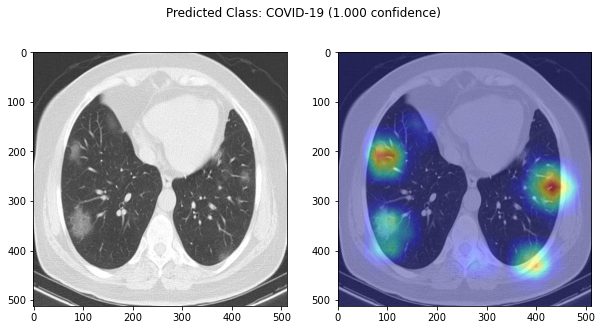

In [22]:
# Prepare image
image = load_and_preprocess([image_file])

# Run Grad-CAM
heatmap, class_pred, class_prob = run_gradcam(
    final_conv, pooled_grads, sess, image)

# Show image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(hspace=0.01)
ax[0].imshow(image[0])
plt.suptitle('Predicted Class: {} ({:.3f} confidence)'.format(CLASS_NAMES[class_pred], class_prob))
ax[1].imshow(image[0])
ax[1].imshow(heatmap, cmap='jet', alpha=0.4)

print('**DISCLAIMER**')
print('Do not use this prediction for self-diagnosis. '
      'You should check with your local authorities for '
      'the latest advice on seeking medical assistance.')
plt.show()

## Full CT volume inference
If a 3D CT volume is available, the slices can be run through the model individually (or in batches) to produce a visualization of the model's predictions per-slice. This can provide regions of interest in the CT volume which may be explored later.

The `volume_path` below should be a directory of images where calling `sorted()` on the list of filenames sorts them in the correct order. If this is not the case, slices may be out of order.

The provided example is a COVID-19-positive patient (confirmed by RT-PCR).

In [23]:
# Select directory of images and set batch size
volume_path = 'assets/volume_example'
batch_size = 1

**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


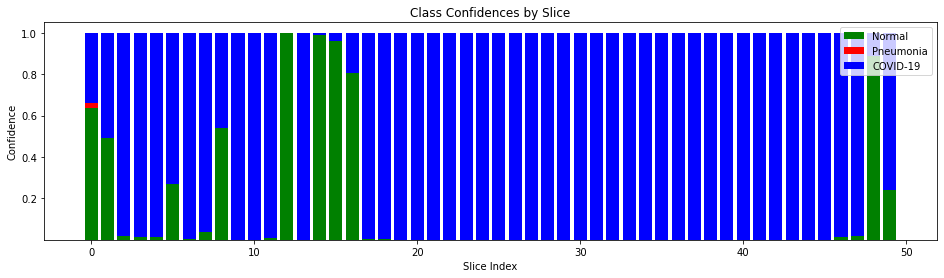

In [24]:
# Prepare images
image_files = sorted(multi_ext_file_iter(volume_path, IMG_EXTENSIONS))
images = load_and_preprocess(image_files)

# Run inference
_, class_probs = run_inference(graph, sess, images, batch_size)

# Display confidences by slice
fig, ax = plt.subplots(figsize=(16, 4))
stacked_bar(ax, class_probs)

print('**DISCLAIMER**')
print('Do not use this prediction for self-diagnosis. '
      'You should check with your local authorities for '
      'the latest advice on seeking medical assistance.')
plt.show()

Now we can run Grad-CAM for the highest and lowest confidence COVID-19 slices to see what the model is doing behind the scenes.

**DISCLAIMER**
Do not use this prediction for self-diagnosis. You should check with your local authorities for the latest advice on seeking medical assistance.


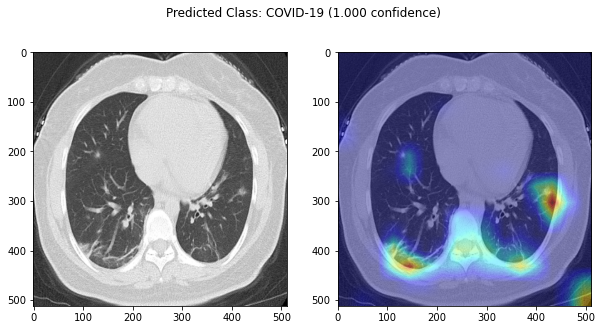

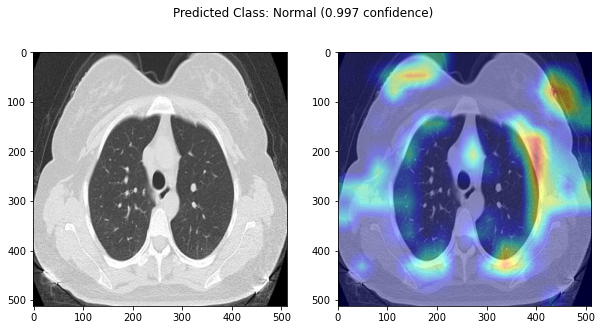

In [25]:
# Get high/low image indices
idx_hi = np.argmax(class_probs[:, 2])
idx_lo = np.argmin(class_probs[:, 2])

for idx in (idx_hi, idx_lo):
    # Select image
    image = images[None, idx]

    # Run Grad-CAM
    heatmap, class_pred, class_prob = run_gradcam(
        final_conv, pooled_grads, sess, image)

    # Show image
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    plt.subplots_adjust(hspace=0.01)
    ax[0].imshow(image[0])
    plt.suptitle('Predicted Class: {} ({:.3f} confidence)'.format(CLASS_NAMES[class_pred], class_prob))
    ax[1].imshow(image[0])
    ax[1].imshow(heatmap, cmap='jet', alpha=0.4)

print('**DISCLAIMER**')
print('Do not use this prediction for self-diagnosis. '
      'You should check with your local authorities for '
      'the latest advice on seeking medical assistance.')
plt.show()